## Setup

Import necessary modules and dependencies. Note that you'll be using <a href="https://seaborn.pydata.org/" class="external">seaborn</a> for visualization in this tutorial.

### 1-Importing Dependencies

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from tensorflow.keras.models import Sequential
from tensorflow .keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed, GRU, SimpleRNN

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the Urdu voice dataset

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

### 2-Loading Data

In [2]:
DATASET_PATH = 'URDU-Dataset-master/URDU-Dataset-master'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['Angry' 'Happy' 'Neutral' 'Sad']


Extract the audio clips into a list called `filenames`, and shuffle it:

In [4]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 400
Number of examples per label: 100
Example file tensor: tf.Tensor(b'URDU-Dataset-master\\URDU-Dataset-master\\Happy\\SM7_F24_H096.wav', shape=(), dtype=string)


Split `filenames` into training, validation and test sets using a 80:10:10 ratio, respectively:

### 3-Spliting into Train, Val and Test

In [5]:
train_files = filenames[:300]
val_files = filenames[300: 350]
test_files = filenames[350:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 300
Validation set size 50
Test set size 50


### 4-Read single file 

## Read the audio files and their labels

In this section you will preprocess the dataset, creating decoded tensors for the waveforms and the corresponding labels. Note that:

The shape of the tensor returned by `tf.audio.decode_wav` is `[samples, channels]`, where `channels` is `1` for mono or `2` for stereo. The mini Speech Commands dataset only contains mono recordings. 

In [6]:
test_file = tf.io.read_file(DATASET_PATH+'/Angry/SM1_F1_A01.wav')
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([88200, 1])

### 5-Making some Function

Now, let's define a function that preprocesses the dataset's raw WAV audio files into audio tensors:

In [7]:
def decode_audio(audio_binary):
  # Decode WAV-encoded audio files to `float32` tensors, normalized
  # to the [-1.0, 1.0] range. Return `float32` audio and a sample rate.
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # Since all the data is single channel (mono), drop the `channels`
  # axis from the array.
  return tf.squeeze(audio, axis=-1)

Define a function that creates labels using the parent directories for each file:

- Split the file paths into `tf.RaggedTensor`s (tensors with ragged dimensions—with slices that may have different lengths).

In [8]:
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # Note: You'll use indexing here instead of tuple unpacking to enable this
  # to work in a TensorFlow graph.
  return parts[-2]

Define another helper function—`get_waveform_and_label`—that puts it all together:

- The input is the WAV audio filename.
- The output is a tuple containing the audio and label tensors ready for supervised learning.

In [9]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Build the training set to extract the audio-label pairs:

- Create a `tf.data.Dataset` with `Dataset.from_tensor_slices` and `Dataset.map`, using `get_waveform_and_label` defined earlier.

You'll build the validation and test sets using a similar procedure later on.

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

Let's plot a few audio waveforms:

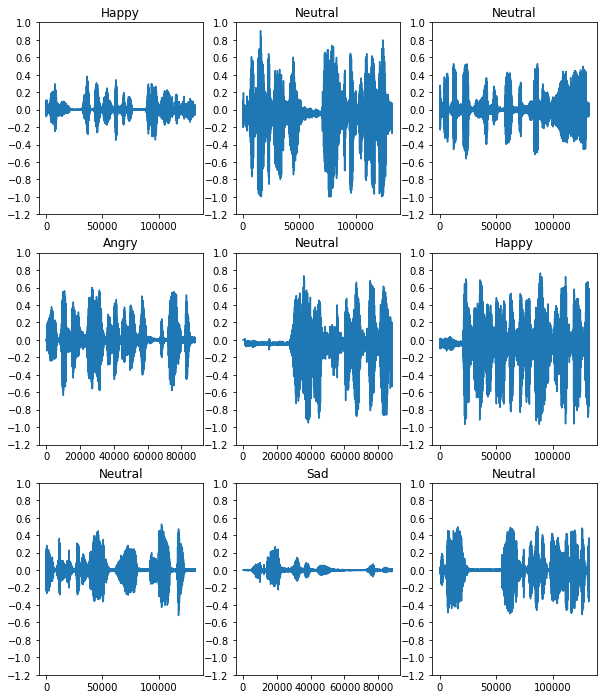

In [11]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

### 6-Convert Wavform to Spectogram

In [12]:
def get_spectrogram(waveform):
  # Zero-padding for an audio waveform with less than 16,000 samples.
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  # Cast the waveform tensors' dtype to float32.
  waveform = tf.cast(waveform, dtype=tf.float32)
  # Concatenate the waveform with `zero_padding`, which ensures all audio
  # clips are of the same length.
  equal_length = tf.concat([waveform, zero_padding], 0)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [13]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: Happy
Waveform shape: (132456,)
Spectrogram shape: (124, 129, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [14]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

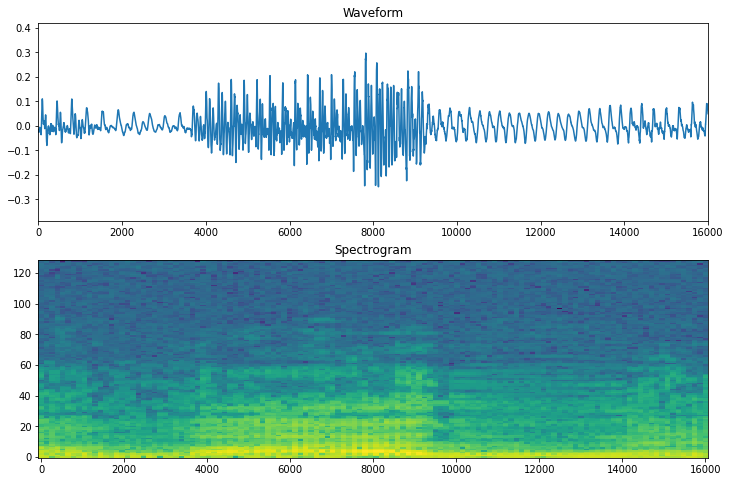

In [15]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Now, define a function that transforms the waveform dataset into spectrograms and their corresponding labels as integer IDs:

In [16]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.math.argmax(label == commands)
  return spectrogram, label_id

Map `get_spectrogram_and_label_id` across the dataset's elements with `Dataset.map`:

In [17]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

Examine the spectrograms for different examples of the dataset:

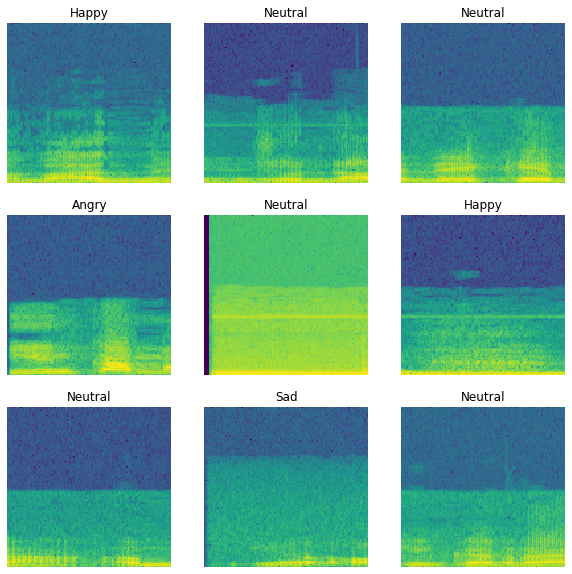

In [18]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')

plt.show()

### 7-Building Model

## Build and train the model

Repeat the training set preprocessing on the validation and test sets:

In [19]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [20]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training:

In [21]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [22]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [23]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model1 = Sequential()
model1.add(Input(shape=input_shape))
model1.add(TimeDistributed(SimpleRNN(60)))
model1.add(SimpleRNN(60))
model1.add(Dense(150,activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(1,activation='sigmoid'))
print(model1.summary())

#compilation
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#fitting
hist1 = model1.fit(train_ds,batch_size=150,epochs=50,validation_data=val_ds)

Input shape: (124, 129, 1)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 124, 60)          3720      
 ibuted)                                                         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 60)                7260      
                                                                 
 dense (Dense)               (None, 150)               9150      
                                                                 
 dropout (Dropout)           (None, 150)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 151       
                                                                 
Total params: 20,281
Trainable params: 20,281
Non-trainable params: 0
_________________________

5/5 [==============================] - 10s 2s/step - loss: -208.7637 - accuracy: 0.2367 - val_loss: -216.2605 - val_accuracy: 0.2600


In [24]:
model2 = Sequential()
model2.add(Input(shape=input_shape))
model2.add(TimeDistributed(GRU(60)))
model2.add(GRU(60))
model2.add(Dense(150,activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(1,activation='sigmoid'))
print(model2.summary())

#compilation
model2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#fitting
hist2 = model2.fit(train_ds,batch_size=150,epochs=50,validation_data=val_ds)
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 124, 60)          11340     
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 60)                21960     
                                                                 
 dense_2 (Dense)             (None, 150)               9150      
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 151       
                                                                 
Total params: 42,601
Trainable params: 42,601
Non-trainable params: 0
__________________________________________________

5/5 [==============================] - 45s 9s/step - loss: -287.8182 - accuracy: 0.2367 - val_loss: -309.3791 - val_accuracy: 0.2600
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, 124, 60)          11340     
 tributed)                                                       
                                                                 
 gru_1 (GRU)                 (None, 60)                21960     
                                                                 
 dense_2 (Dense)             (None, 150)               9150      
                                                                 
 dropout_1 (Dropout)         (None, 150)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 151       
                                                     

In [28]:
model3 = Sequential()
model3.add(Input(shape=input_shape))
model3.add(TimeDistributed(LSTM(60)))
model3.add(LSTM(60))
model3.add(Dense(150,activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1,activation='sigmoid'))
print(model3.summary())

#compilation
model3.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
#fitting
hist3 = model3.fit(train_ds,batch_size=150,epochs=50,validation_data=val_ds)
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 124, 60)          14880     
 tributed)                                                       
                                                                 
 lstm_5 (LSTM)               (None, 60)                29040     
                                                                 
 dense_8 (Dense)             (None, 150)               9150      
                                                                 
 dropout_4 (Dropout)         (None, 150)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 151       
                                                                 
Total params: 53,221
Trainable params: 53,221
Non-trainable params: 0
__________________________________________________

5/5 [==============================] - 46s 9s/step - loss: -285.9034 - accuracy: 0.2367 - val_loss: -307.1877 - val_accuracy: 0.2600
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_4 (TimeDis  (None, 124, 60)          14880     
 tributed)                                                       
                                                                 
 lstm_5 (LSTM)               (None, 60)                29040     
                                                                 
 dense_8 (Dense)             (None, 150)               9150      
                                                                 
 dropout_4 (Dropout)         (None, 150)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 151       
                                                     

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

Train the model over 50 epochs for demonstration purposes:

Let's plot the training and validation loss curves to check how your model has improved during training:

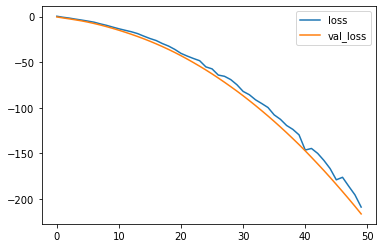

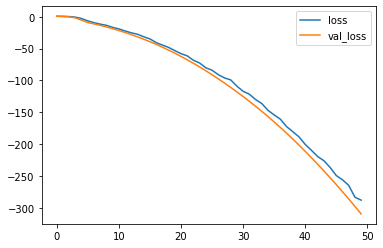

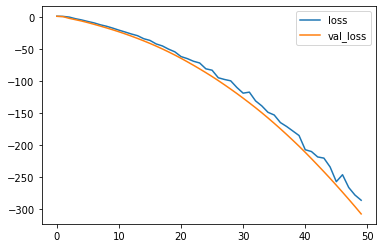

In [29]:
metrics = hist1.history
plt.plot(hist1.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

metrics = hist2.history
plt.plot(hist2.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

metrics = hist3.history
plt.plot(hist3.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

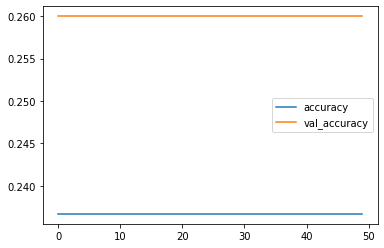

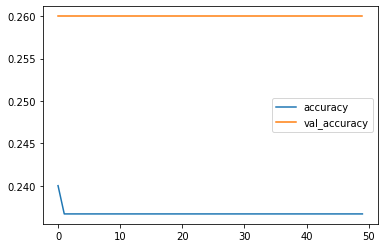

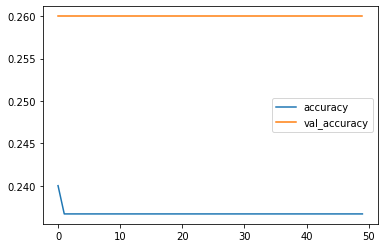

In [32]:
metrics = hist1.history
plt.plot(hist1.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

metrics = hist2.history
plt.plot(hist2.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

metrics = hist3.history
plt.plot(hist3.epoch, metrics['accuracy'], metrics['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

### 8-Evalute Model

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [30]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [31]:
y_pred1 = np.argmax(model1.predict(test_audio), axis=1)
y_true1 = test_labels

test_acc1 = sum(y_pred1 == y_true1) / len(y_true1)
print(f'Test set accuracy: {test_acc1:.0%}')

y_pred2 = np.argmax(model2.predict(test_audio), axis=1)
y_true2 = test_labels

test_acc2 = sum(y_pred2 == y_true2) / len(y_true2)
print(f'Test set accuracy: {test_acc2:.0%}')

y_pred3 = np.argmax(model3.predict(test_audio), axis=1)
y_true3 = test_labels

test_acc3 = sum(y_pred2 == y_true2) / len(y_true2)
print(f'Test set accuracy: {test_acc3:.0%}')

2/2 [==============================] - 10s 223ms/step
Test set accuracy: 22%
2/2 [==============================] - 25s 943ms/step
Test set accuracy: 22%
2/2 [==============================] - 5s 1s/step
Test set accuracy: 22%


### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the commands in the test set:


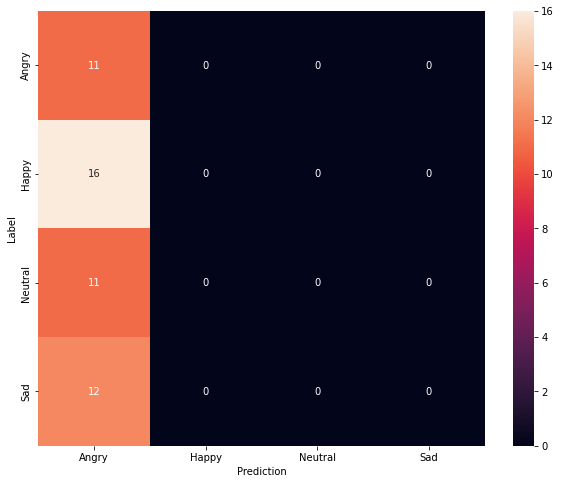

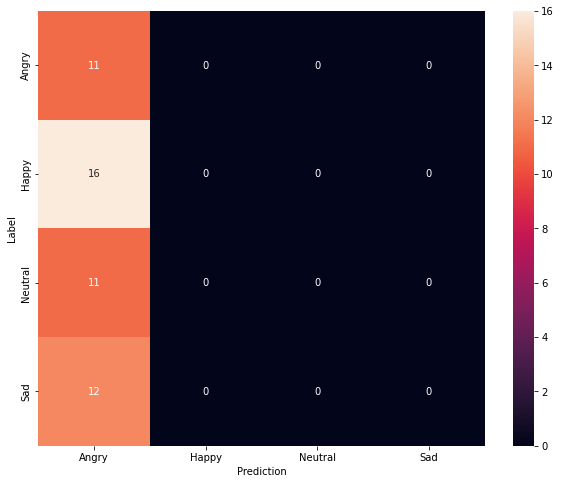

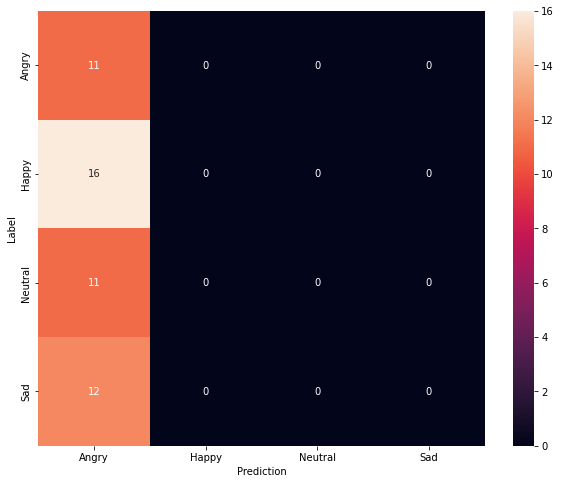

In [33]:
confusion_mtx = tf.math.confusion_matrix(y_true1, y_pred1)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

confusion_mtx = tf.math.confusion_matrix(y_true2, y_pred2)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

confusion_mtx = tf.math.confusion_matrix(y_true3, y_pred3)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=commands,
            yticklabels=commands,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

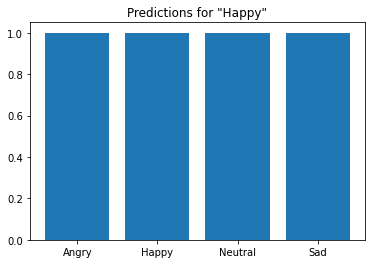

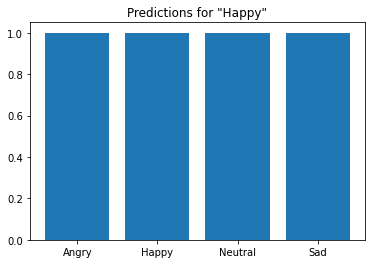

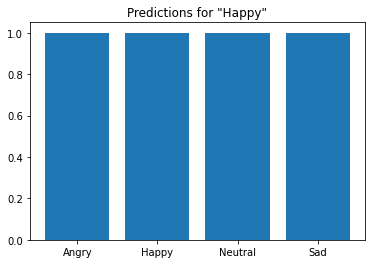

In [34]:
sample_file = data_dir/'Happy/SF1_F1_H01.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model1(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()
    
for spectrogram, label in sample_ds.batch(1):
  prediction = model2(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()
    
for spectrogram, label in sample_ds.batch(1):
  prediction = model3(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

As the output suggests, your model should have recognized the audio command as "Happy".
But the wrong Prediction mean that our model has some problem in tunning parameters.